In [144]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import os
import tifffile as tiff
from glob import glob
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from skimage import io
import cv2
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score






if torch.cuda.is_available():
    print("Using GPU...")
    dev = "cuda:0"
else:
    print("Using CPU...")
    dev = "cpu"
    
    
device = torch.device(dev)






#Set the random seed for reproducibility 
torch.manual_seed(2020) 



class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Transform the 28 by 28 image to an embedded code size of 30
            nn.Linear(38400, 30),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 38400),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        # x will be a (batch_size,1,28,28) tensor when using MNIST
        # so we will reshape it to a (batch_size, 28*28) flat tensor.
        # After it has been decoded we will reshape back to the image shape.
        x = self.encoder(x.view(-1, 38400))
        x = self.decoder(x)
        return x.view(-1, 1, 160, 240)




class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0) # conv layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x







class ConvAutoencoder2D(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2D, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0), # conv layer
            nn.ReLU(),
            #nn.Linear( 64*1*1, 2)
            nn.Linear( 64*1*1, 2)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Using GPU...


In [2]:
imgA = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all/Test017_141.tif'
imgB = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all/Test017_143.tif'


imlist = [imgA,imgB]

w,h=Image.open(imlist[0]).size
N=len(imlist)

arr=np.zeros((h,w),float)


for im in imlist:
    imarr=np.array(Image.open(im),dtype=float)
    arr=arr+imarr/N


arr=np.array(np.round(arr),dtype=np.uint8)

out=Image.fromarray(arr)
#out.save("017_142.tif")
#out.show()


path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all'
imageList = [os.path.join(path, file) for file in os.listdir(path)]
print(imageList[0])

w,h=Image.open(imageList[0]).size
N=len(imageList)

avgArr=np.zeros((h,w),float)

for im in imageList:
    imageArr=np.array(Image.open(im),dtype=float)
    avgArr=avgArr+imageArr/N
    
avgArr=np.array(np.round(avgArr),dtype=np.uint8)
    
avg=Image.fromarray(avgArr)
#avg.save("Test_avg.tif")
avg.show()

    


./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all\Test001_001.tif


In [2]:
num_epochs = 30

"""
class AnomalyDataset(data.Dataset):
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.folder_names = os.listdir(self.img_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.folder_names)
        
    
    def __getitem__(self, index):
        #img_path = self.img_dir[index]
        #image = Image.open(img_path)
        #avg = Image.open('Test_avg.tif')
        #image1 = np.asarray(image)
        #image2 = np.asarray(avg)
        #image = image1 - image2
        #image = Image.fromarray(image)
        #image.show()
        #if self.transform:
        #    image = self.transform(image)
        
        folder_path = os.path.join(self.img_dir, self.folder_names[index])
        image_filenames = os.listdir(folder_path)
        
        images = []
        for img in image_filenames:
            if img.endswith('.tif'):
                image_path = os.path.join(folder_path, img)
                image = Image.open(image_path)
            
                if self.transform:
                    image = self.transform(image)
                images.append(image)
            
        return images
      
      
"""   

        
path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/All_data'
data_transforms = transforms.Compose([transforms.Resize((160, 240)), transforms.ToTensor()])

#dataset = AnomalyDataset(path, data_transforms)



#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    
    

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/All_data'
num_folders = 70
num_images_per_folder = 200
image_height = 160
image_width = 240

dataset = np.zeros((num_folders, num_images_per_folder, image_height, image_width))

for i in range(num_folders):
    folder_name = str(i+1).zfill(3)
    folder_path = os.path.join(root_dir, folder_name)

    for j in range(num_images_per_folder):
        image_name = str(j+1).zfill(3) + '.tif'
        image_path = os.path.join(folder_path, image_name)

        image = Image.open(image_path)
        image = image.resize((240, 160))
        
        image = np.array(image)
        dataset[i, j, :, :] = image
    
    
    
print(dataset.shape)

dataset_tensor = torch.tensor(dataset)
print(dataset_tensor.shape)



                
                
            
            
            
            

#image_path_train = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train_all'
#image_paths_train = glob(image_path_train + '/*.tif')
#data_transforms = transforms.Compose([transforms.Resize((160, 240)), transforms.ToTensor()])



#image_path_test = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all'
#image_paths_test = glob(image_path_test + '/*.tif')

#dataset_train = AnomalyDataset(image_paths_train, data_transforms)
#dataset_train2 = AnomalyDataset(image_paths_test, data_transforms)




#dataset = UCSDAnomalyDataset('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train', time_stride=1)
#data_train = data.DataLoader(dataset, batch_size=32, shuffle=True)



(70, 200, 160, 240)
torch.Size([70, 200, 160, 240])


In [3]:
label_start = 34
labels = np.zeros((num_folders, num_images_per_folder, 1))
"""    
labels = np.zeros(7200, dtype=np.int8)
import csv
with open('labels.txt', 'r') as file:
    for i, line in enumerate(file):
        if("," in line):
            #part1 = line.rstrip().split(',')[0]
            #part2 = line.rstrip().split(',')[1]
            start1 = int(line.rstrip().split(',')[0].split(':')[0])-1+(i*200)
            end1 = int(line.rstrip().split(',')[0].split(':')[1])+1+(i*200)
            
            labels[start1:end1] = 1
            
            start2 = int(line.rstrip().split(',')[1].split(':')[0])-1+(i*200)
            end2 = int(line.rstrip().split(',')[1].split(':')[1].replace(';', ''))+1+(i*200)
            
            labels[start2:end2] = 1
            
            
        else:
            start3 = int(line.rstrip().split(';')[0].split(':')[0])-1+(i*200)
            end3 = int(line.rstrip().split(';')[0].split(':')[1])+1+(i*200)
            #s = slice(*map(int, frames.split(':')))
            #print(s)
            labels[start3:end3] = 1
            
"""
            
            
            
with open("labels.txt", "r") as f:
    for i, line in enumerate(f):
        # Split the line by semicolons and commas
        parts = line.strip().split(";")
        if ("," in line):
            indices = parts[0].strip().split(",")
            for index in indices:
                start, end = index.strip().split(":")
                start = int(start) - 1
                end = int(end) - 1
                
                labels[i+label_start, start:end, 0] = 1
        else:
            start, end = parts[0].strip().split(":")
            start = int(start) - 1
            end = int(end) - 1
            
            labels[i+label_start, start:end, 0] = 1
                
                
                
print(labels.shape)

(70, 200, 1)


In [9]:
def train_AE(model, dataset, max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    batch_size=64
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Storage
    outputs = []
    
    model.to(device)
    #train_loader = train_loader.cuda()

    #Start training
    for epoch in range(max_epochs):
        for img in train_loader:
            img = img.to(device)
            recon = model(img.float())
            #print(recon.shape)
            loss = criterion(recon, img.to(device))

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        #if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
        outputs.append((epoch, img.detach(), recon.detach()),)

    return outputs

torch.Size([56, 200, 160, 240])


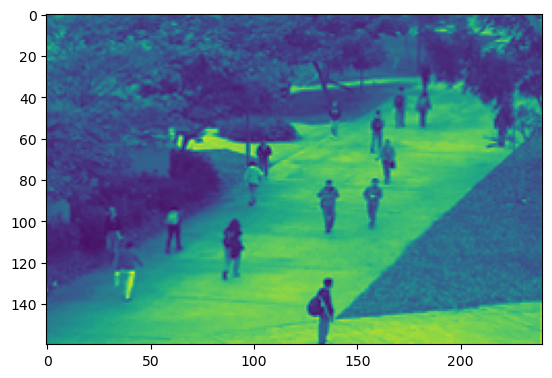

==========PCA TRAIN==========
(11200, 38400)
(11200, 38400)


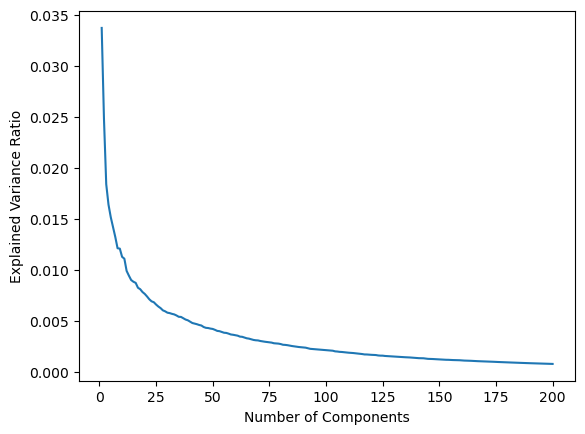

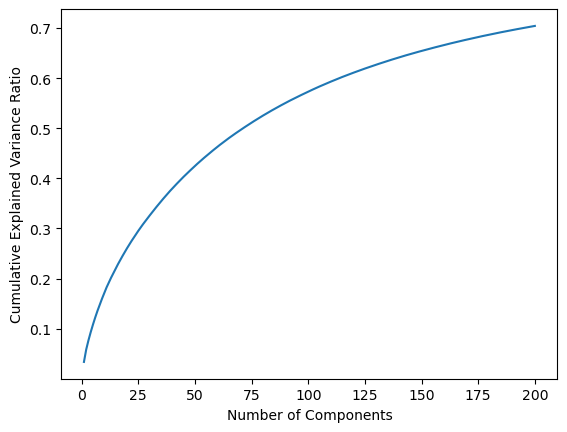

Reconstruction error is  94.695234561198





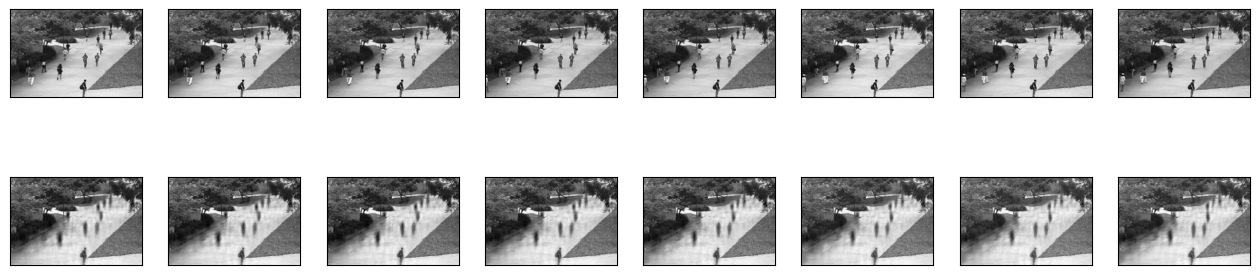

(11200, 38400)
(11200, 38400)


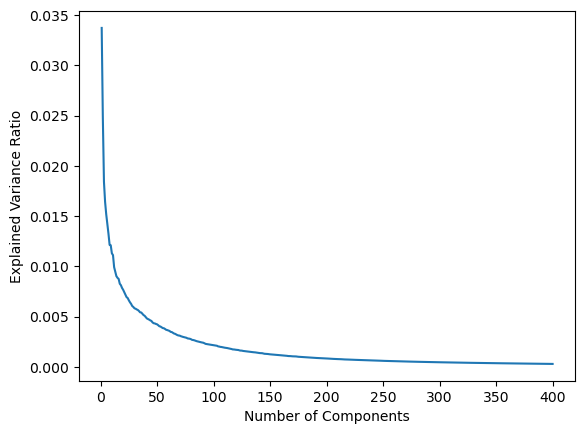

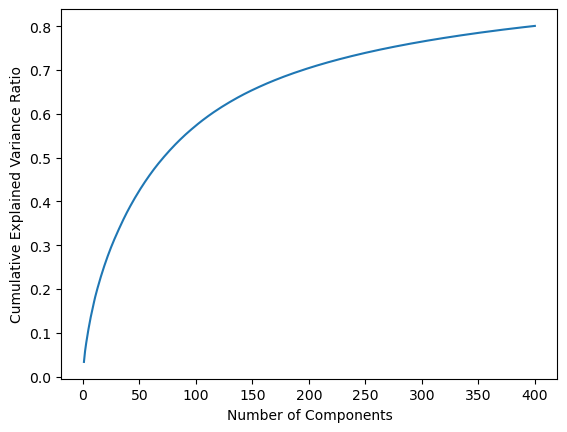

Reconstruction error is  63.7910073508602





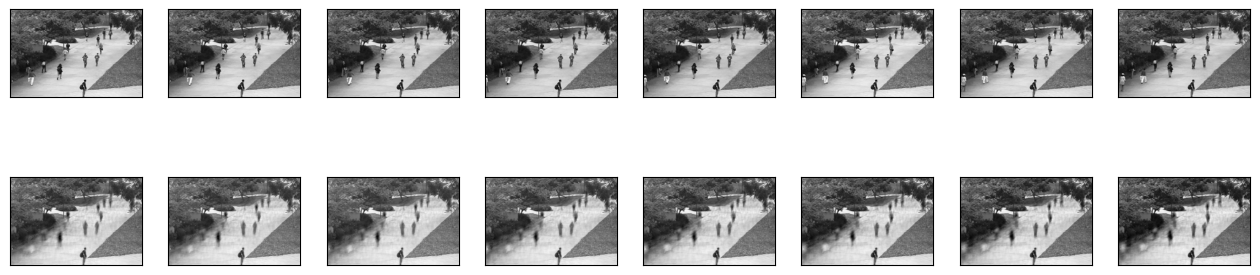

(11200, 38400)
(11200, 38400)


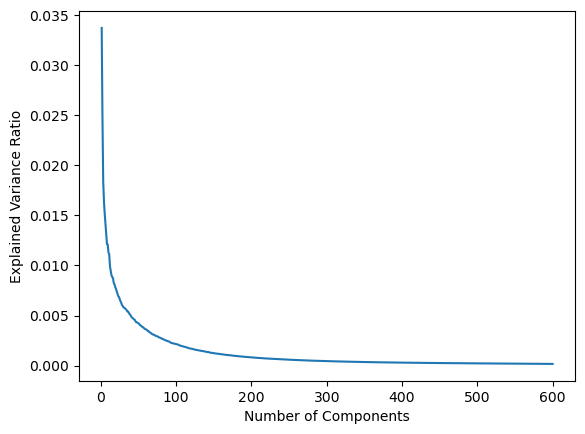

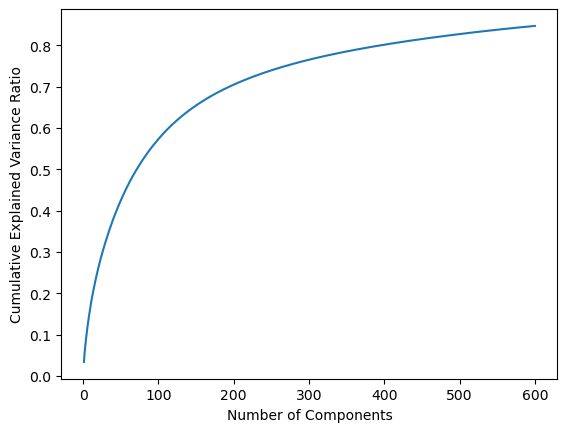

Reconstruction error is  49.0909127134806





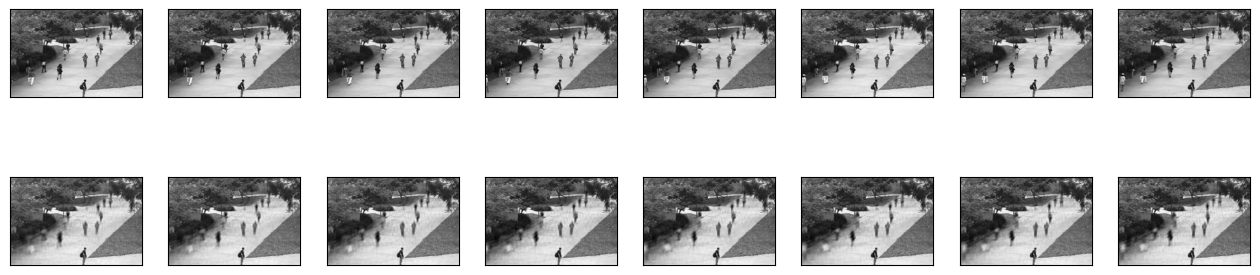

==========PCA TEST==========
(2800, 38400)
(2800, 38400)


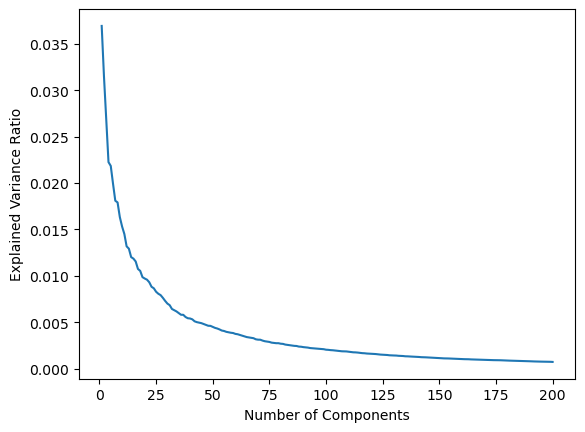

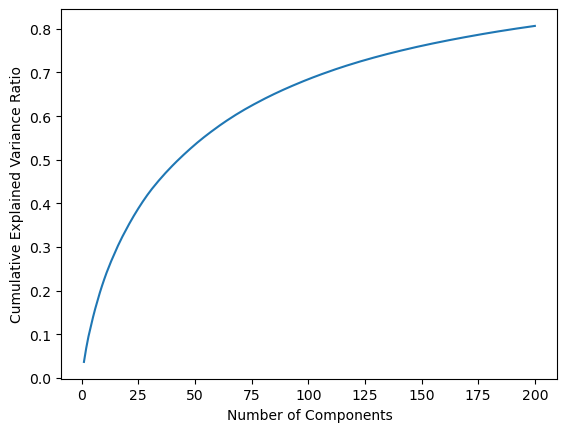

Reconstruction error is  63.25930780522193





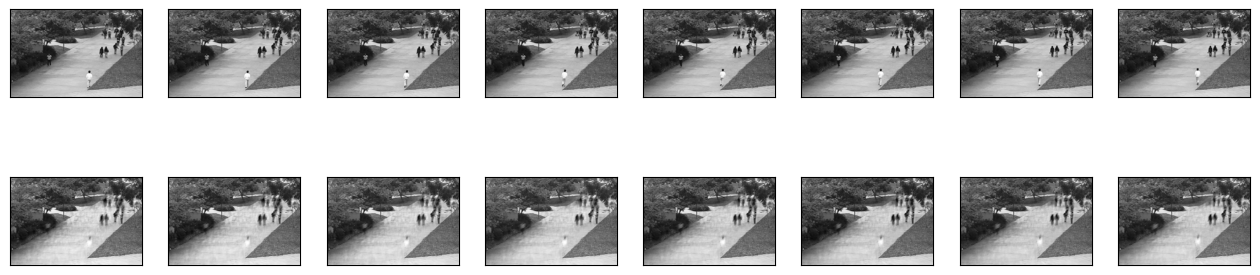

(2800, 38400)
(2800, 38400)


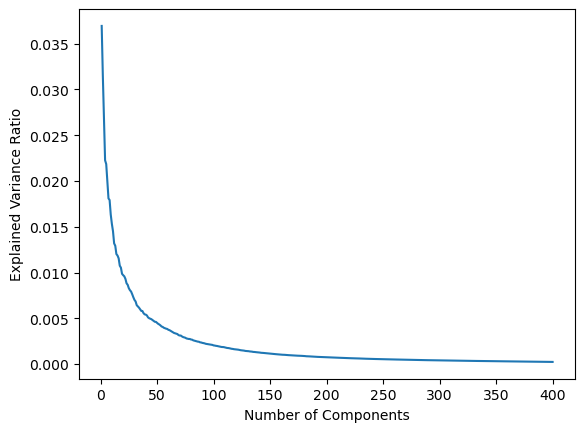

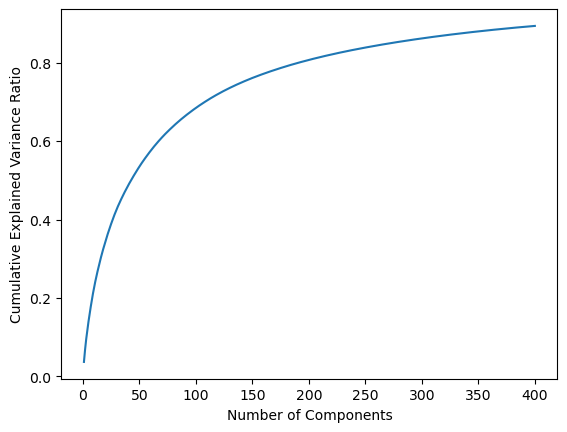

Reconstruction error is  34.764202338545694





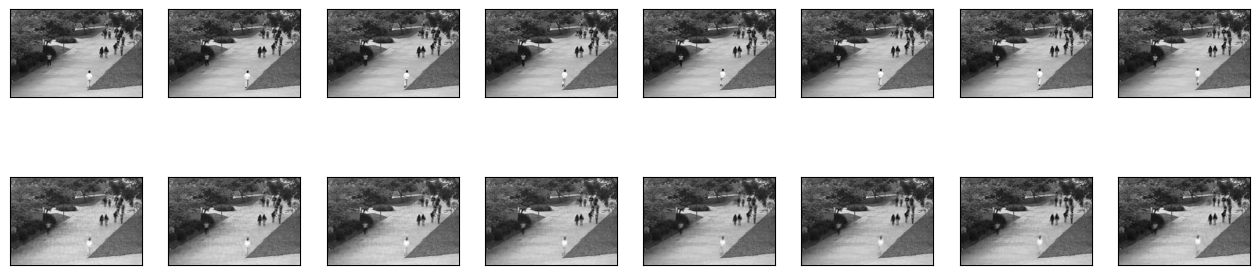

(2800, 38400)
(2800, 38400)


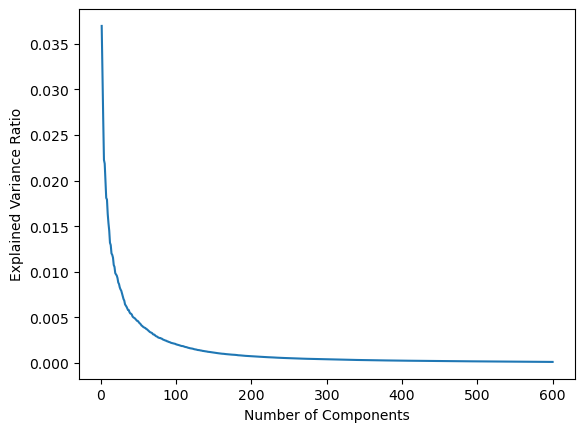

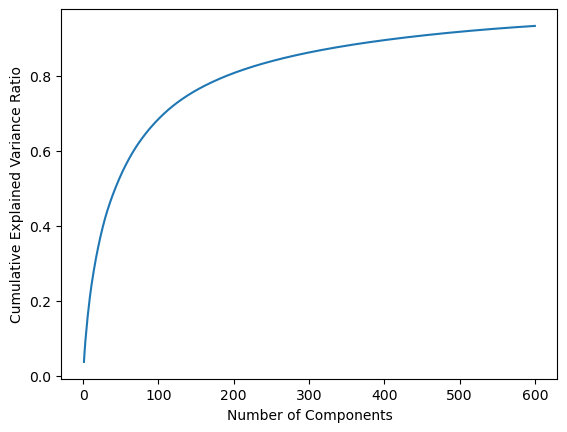

Reconstruction error is  22.012432833295964





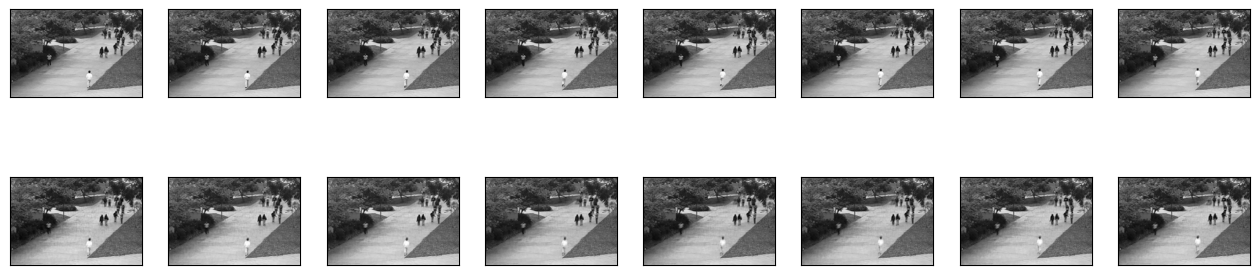

In [4]:

X_train, X_test, y_train, y_test = train_test_split(dataset_tensor, labels, test_size=0.2, random_state=42)
print(X_train.shape)


img = Image.fromarray(np.uint8(X_train[0][0]))

# display the image using matplotlib
plt.imshow(img)
plt.show()





#cae.to(device)

def do_pca(n_components, dataset):
    
    pca = PCA(n_components)
    
    dataset = dataset.numpy()
    num_videos, num_frames, height, width = dataset.shape
    data = dataset.reshape(num_videos*num_frames, height*width)
    print(data.shape)
    
    transformed_images = pca.fit_transform(data)
    reconstructed_images = pca.inverse_transform(transformed_images)
    print(reconstructed_images.shape)
    

    #print(np.cumsum(pca.explained_variance_ratio_))

    plt.plot(np.arange(1,n_components+1), pca.explained_variance_ratio_)
    # Plotting using a log scale might show more information
    #plt.yscale('log')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()

    plt.plot(np.arange(1,n_components+1), np.cumsum(pca.explained_variance_ratio_))
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()
    



    reconstruction_error = mean_squared_error(data, reconstructed_images)
    print('Reconstruction error is ', reconstruction_error)
    print("\n\n")

    plt.figure(figsize=(16, 4))
    for i in range(8):
        # Top row: show original faces
        plt.subplot(2,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i].reshape(160,240), cmap='Greys_r')
        # Bottom row: show reconstructions
        plt.subplot(2,8, 8+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(reconstructed_images[i].reshape(160,240), cmap='Greys_r')
    plt.show()
    
    return transformed_images

    
    
print("==========PCA TRAIN==========")
pca_200_train = do_pca(200, X_train)
pca_400_train = do_pca(400, X_train)
pca_600_train = do_pca(600, X_train)






print("==========PCA TEST==========")
pca_200_test = do_pca(200, X_test)
pca_400_test = do_pca(400, X_test)
pca_600_test = do_pca(600, X_test)



In [10]:
ae = Autoencoder()
cae = ConvAutoencoder()
cae2D = ConvAutoencoder2D()

#print(ae)
#print("==============Standard Autoencoder===========")
#outputs = train_AE(ae, dataset, max_epochs=30, print_steps=30)
#print("\n\n")

"""
numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].numpy()    
    recon = outputs[k][2].numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
"""


print("==============ConvAutoencoder TRAIN==============")
outputs = train_AE(cae, X_train, max_epochs=30, print_steps=30)
print("\n\n")



        
        
print("\n\n")
print("==============ConvAutoencoder TEST==============")
outputs = train_AE(cae, X_test, max_epochs=30, print_steps=30)
print("\n\n")



        
numOut = len(outputs)-1
numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].cpu().numpy()    
    recon = outputs[k][2].cpu().numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        

plt.figure(figsize=(16, 4))
imgs = outputs[numOut][1].cpu().numpy()    
recon = outputs[numOut][2].cpu().numpy()

for i in range(8):
    # Top row: show original faces
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i][0].reshape(160,240), cmap='Greys_r')
    # Bottom row: show reconstructions
    plt.subplot(2,8, 8+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recon[i][0].reshape(160,240), cmap='Greys_r')
plt.show()
        

==============ConvAutoencoder TRAIN==============


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[56, 200, 160, 240] to have 1 channels, but got 200 channels instead

In [9]:
class LinearRegression(torch.nn.Module):

    def __init__(self): 
        super(LinearRegression, self).__init__() 
        self.linear = torch.nn.Linear(38400, 1)

      
    def forward(self, x): 

        predict_y = self.linear(x) 
        return predict_y
    


In [10]:
def trainLinearModel(model, dataset, labels, max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    
    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    labels = torch.from_numpy(labels)
    images = torch.from_numpy(dataset)
    

    

    #Storage
    outputs = []
    
    model.to(device)

    #Start training
    for epoch in range(max_epochs):
        for img, label in images:
            img = img.to(device)
            predict = model(img.float())
            #print(recon.shape)
            loss = criterion(predict, labels)

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        #if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
        outputs.append((epoch, img.detach(), recon.detach()),)

    return outputs

In [9]:
#print(outputs[29][1].cpu().numpy().shape)
#print(outputs[29][])
#print(pca_400.shape)

#linearModel = LinearRegression()

#linearOutputs = trainLinearModel(linearModel, pca_400, labels, 50, 50)

V, F = y_train.shape[:2]
labels_train = np.reshape(y_train, (V*F, 1))

V, F = y_test.shape[:2]
labels_test = np.reshape(y_test, (V*F, 1))
labels_test_log = labels_test.ravel()
labels_train_log = labels_train.ravel()

linearPCA = RidgeClassifier().fit(pca_200_train, labels_train_log)

y_pred = linearPCA.predict(pca_200_test)
accuracy = accuracy_score(labels_test_log, y_pred)
print("Accuracy of Ridge Classifier: ", accuracy)

#linearPCA.score(pca_400_test, labels_test)


clf = LogisticRegression().fit(pca_200_train, labels_train_log)
pred = clf.predict(pca_200_test)
acc = accuracy_score(labels_test_log, pred)

print("Accuracy of Logistic Regression: ", acc)



    


#linearAE = RidgeClassifier().fit(outputs[29][1].cpu().numpy().flatten().reshape(-1, 1), labels)
#linearAE.score(outputs[29][1].cpu().numpy(), labels)

Accuracy of Ridge Classifier:  0.6785714285714286
Accuracy of Logistic Regression:  0.6639285714285714


In [139]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, alpha=0.95, sparsity=0.1):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size

        self.W_in = np.random.randn(reservoir_size, input_size)
        self.W_res = np.random.randn(reservoir_size, reservoir_size)
        self.W_out = np.random.randn(output_size, reservoir_size)
        
        self.alpha = alpha
        
        e, v = np.linalg.eig(self.W_res)
        max_abs = np.max(np.abs(e))
        self.W_res = self.W_res/max_abs
        M = (np.random.uniform(size=(reservoir_size, reservoir_size)) < sparsity) * 1.0
        self.W_res *= M
        
        self.h0 = np.zeros((reservoir_size, 1))
        

        
        
        
        
    def update(self, x):
        h = self.h0
        T = x.shape[0]
        states = []

        
        for t in range(T):
            h = self.alpha * np.tanh(self.W_res @ h + self.W_in @ x[t].reshape(-1, 1))
            states.append(h.ravel())
        states = np.vstack(states)
        return states
    
    
    def fit(self, X, y):
        self.train_states = self.update(X)
        ridge = Ridge(alpha=0.5)
        ridge.fit(self.train_states, y)
        self.W_out = ridge.coef_
        return self.W_out
    
    
    def predict(self, X):
        states = self.update(X)
        y_pred = states @ self.W_out.T
        return (y_pred >= 0.5).astype(int)            
        

        
        
        
        
        
        

    





In [145]:
input_size = 400
reservoir_size = 400
output_size = 1
epochs = 400




esn = ESN(input_size, reservoir_size, output_size)

#train_ESN(esn, pca_400, labels, epochs)

#VF, D = pca_400_train.shape
#V = VF/200
#F = 200
#train_data = pca_400_train.reshape(V, F, D)



train_states = esn.fit(pca_400_train, labels_train)
y_pred = esn.predict(pca_400_test)

esn_accuracy = accuracy_score(labels_test, y_pred)
print("ESN Accuracy: ", esn_accuracy)
auc_score = roc_auc_score(labels_test, y_pred)
print("ESN AUC: ", auc_score)

ESN Accuracy:  0.8282142857142857
ESN AUC:  0.5007703472577966
